In [1]:
# Import des bibliothèques nécessaires
import os
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from mlflow.models.signature import infer_signature
import shap

/Users/sebastienmorichon/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration de l'URI MLFlow
os.environ["MLFLOW_TRACKING_URI"] = "http://127.0.0.1:5000"

In [3]:
# 1. Chargement et prétraitement des données
start_time = time.time()
data = pd.read_csv("Base De Donnée Prétraitée.csv")
print(f"Temps de chargement des données : {time.time() - start_time:.2f} secondes")

Temps de chargement des données : 2.66 secondes


In [4]:
# Séparer les caractéristiques et la cible
y = data['TARGET']
X = data.drop(columns=['TARGET'])

In [5]:
# Imputation et Normalisation des Données
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
# Appliquer l'imputation et la normalisation sur le jeu d'entraînement uniquement
X = imputer.fit_transform(X)
X = scaler.fit_transform(X)

In [7]:
# Sauvegarder le scaler et l'imputer pour la reproductibilité
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("imputer.pkl", "wb") as f:
    pickle.dump(imputer, f)

In [8]:
# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# Fonction pour tracer et loguer la matrice de confusion
def plot_and_log_confusion_matrix(model_name, y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Non-défaillant', 'Défaillant'], yticklabels=['Non-défaillant', 'Défaillant'])
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()

In [10]:
# Définir l'expérience par défaut au début du code
mlflow.set_experiment("OC-07 V1")

<Experiment: artifact_location='mlflow-artifacts:/383758220160309563', creation_time=1731659538695, experiment_id='383758220160309563', last_update_time=1731659538695, lifecycle_stage='active', name='OC-07 V1', tags={}>

In [11]:
# Fonction pour évaluer et loguer un modèle avec MLFlow
def evaluate_and_log_model(model, model_name, model_type):
    with mlflow.start_run():
        # Entraînement du modèle
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        mlflow.log_metric("training_time", training_time)

        # Prédiction et évaluation
        start_time = time.time()
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        prediction_time = time.time() - start_time
        mlflow.log_metric("prediction_time", prediction_time)

        # Calcul des métriques
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn

        # Log des métriques et du modèle
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_param("model_type", model_type)
        mlflow.sklearn.log_model(model, model_name)

        print(f"{model_name} - AUC: {auc}, Accuracy: {accuracy}, Cost: {cost}")
        plot_and_log_confusion_matrix(model_name, y_test, y_pred)

In [12]:
# 2. Tester plusieurs modèles pour trouver le plus performant
models = [
    (DecisionTreeClassifier(class_weight='balanced', random_state=0), "DecisionTreeClassifier", "Decision Tree"),
    (RandomForestClassifier(class_weight='balanced', random_state=0), "RandomForestClassifier", "Random Forest"),
    (ExtraTreesClassifier(class_weight='balanced', random_state=0), "ExtraTreesClassifier", "Extra Trees"),
    (GradientBoostingClassifier(random_state=0), "GradientBoostingClassifier", "Gradient Boosting"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0), "XGBClassifier", "XGBoost"),
    (LGBMClassifier(random_state=0), "LGBMClassifier", "LightGBM"),
    (CatBoostClassifier(verbose=0, random_state=0), "CatBoostClassifier", "CatBoost")
]

Évaluation des modèles:   0%|          | 0/7 [00:00<?, ?it/s]


Évaluation du modèle : DecisionTreeClassifier


2024/11/15 09:41:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTreeClassifier - AUC: 0.5390601377236862, Accuracy: 0.8568525112596134, Cost: 45434


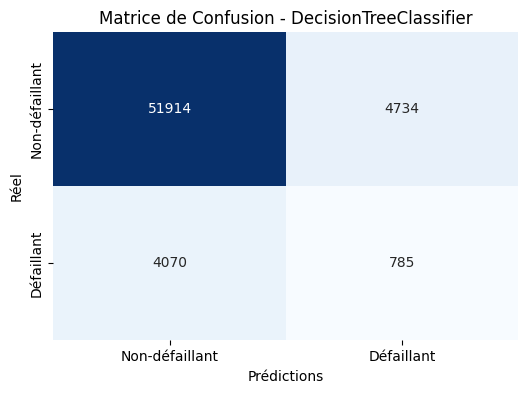

2024/11/15 09:41:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-gnat-262 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/78eb89103e5a4ff2a4b02d09f354aac2.
2024/11/15 09:41:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles:  14%|█▍        | 1/7 [00:20<02:04, 20.68s/it]


Évaluation du modèle : RandomForestClassifier


2024/11/15 09:42:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier - AUC: 0.7210187697135879, Accuracy: 0.9210770206331399, Cost: 48459


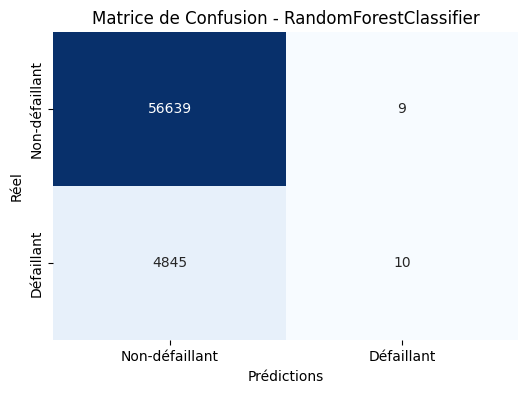

2024/11/15 09:42:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-roo-905 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/83a0aa81477a43c9a98fa509dcd775bc.
2024/11/15 09:42:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles:  29%|██▊       | 2/7 [01:29<04:03, 48.78s/it]


Évaluation du modèle : ExtraTreesClassifier


2024/11/15 09:43:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ExtraTreesClassifier - AUC: 0.7070100653014528, Accuracy: 0.9211095393720632, Cost: 48502


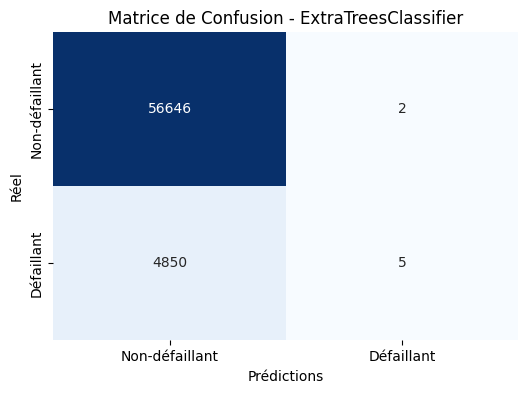

2024/11/15 09:43:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-turtle-941 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/aa36d186afff4d70ae03620e310d69df.
2024/11/15 09:43:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles:  43%|████▎     | 3/7 [02:32<03:41, 55.42s/it]


Évaluation du modèle : GradientBoostingClassifier


2024/11/15 09:48:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoostingClassifier - AUC: 0.7582432503482215, Accuracy: 0.9211420581109865, Cost: 47915


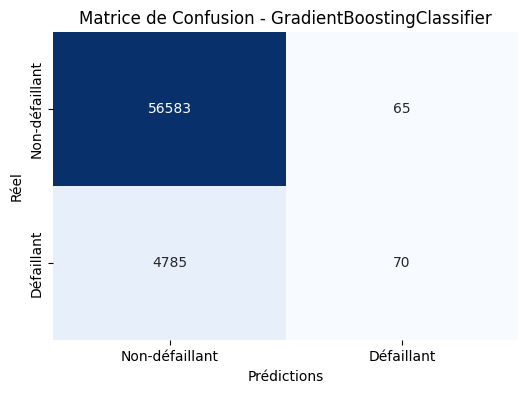

2024/11/15 09:48:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-crane-219 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/d0a6832b58c041fa98573e667c25a1f1.
2024/11/15 09:48:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles:  57%|█████▋    | 4/7 [07:20<07:21, 147.21s/it]


Évaluation du modèle : XGBClassifier


/opt/anaconda3/envs/DS_PROJET_7/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:48:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/11/15 09:48:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier - AUC: 0.7578963868294072, Accuracy: 0.920182755312749, Cost: 47137


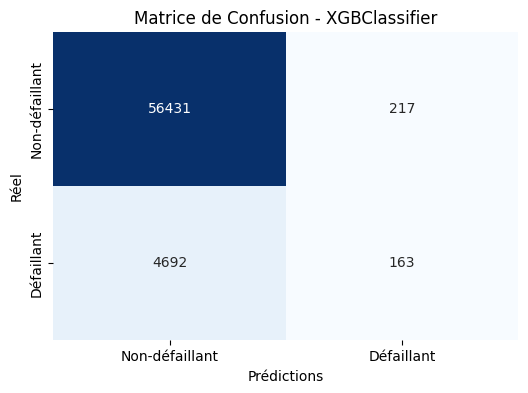

2024/11/15 09:48:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-hen-333 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/dd755ea989d74fe683d118e9fcc3e618.
2024/11/15 09:48:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles:  71%|███████▏  | 5/7 [07:26<03:12, 96.16s/it] 


Évaluation du modèle : LGBMClassifier
[LightGBM] [Info] Number of positive: 19970, number of negative: 226038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12884
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081176 -> initscore=-2.426472
[LightGBM] [Info] Start training from score -2.426472


2024/11/15 09:48:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LGBMClassifier - AUC: 0.7635729256764197, Accuracy: 0.921304651805603, Cost: 47635


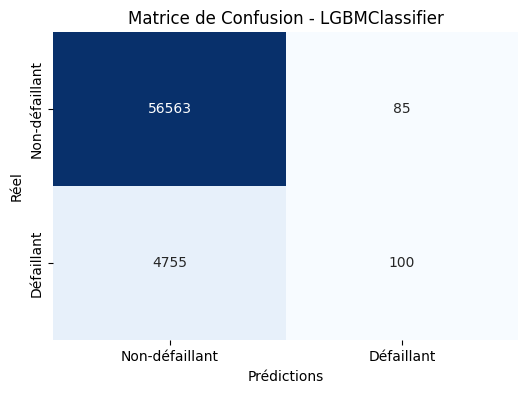

2024/11/15 09:48:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-kite-712 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/b3cfb0388b0c417ea4d1c2240f8c4502.
2024/11/15 09:48:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles:  86%|████████▌ | 6/7 [07:31<01:05, 65.30s/it]


Évaluation du modèle : CatBoostClassifier


2024/11/15 09:49:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CatBoostClassifier - AUC: 0.7677298447812433, Accuracy: 0.9207843519828302, Cost: 47235


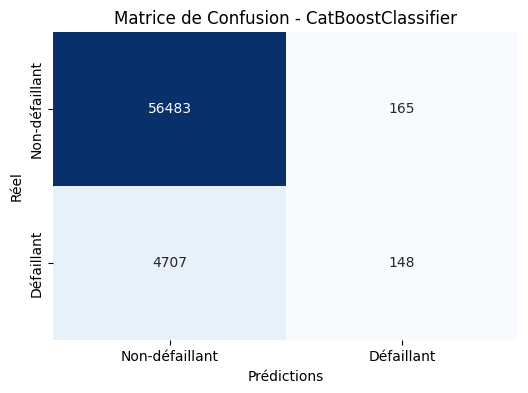

2024/11/15 09:49:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-chimp-884 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/edad6cc9cf454bf6b5193db25aa0a340.
2024/11/15 09:49:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.
Évaluation des modèles: 100%|██████████| 7/7 [08:20<00:00, 71.46s/it]


In [13]:
for model, model_name, model_type in tqdm(models, desc="Évaluation des modèles"):
    print(f"\nÉvaluation du modèle : {model_name}")
    evaluate_and_log_model(model, model_name, model_type)

In [14]:
# 3. Optimisation du modèle le plus performant (LightGBM) avec GridSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

In [15]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 19970, number of negative: 226038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12884
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 19970, number of negative: 226038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12884
[LightGBM] [Info] Number of data points in t

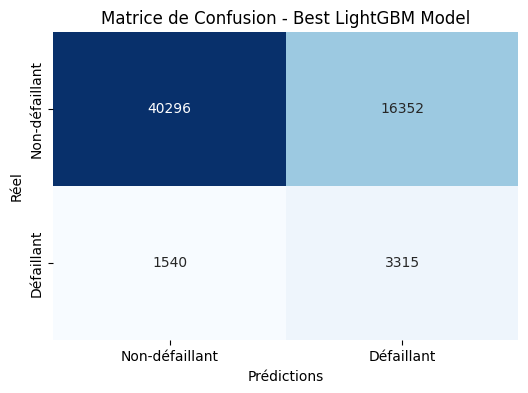

2024/11/15 09:55:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-ox-410 at: http://127.0.0.1:5000/#/experiments/383758220160309563/runs/6d1ebe3715fa42a48a115d3d59278002.
2024/11/15 09:55:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/383758220160309563.


In [16]:
with mlflow.start_run():
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    grid_search_time = time.time() - start_time
    mlflow.log_metric("grid_search_time", grid_search_time)

    # Meilleur modèle et ses paramètres
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # Entraînement et évaluation du meilleur modèle
    start_time = time.time()
    best_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    start_time = time.time()
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn

    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Cost", cost)
    mlflow.log_param("model_type", "Best LightGBM")

    # Enregistrer le modèle et sa signature
    signature = infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "best_lightgbm_model", signature=signature)

    print(f"Meilleurs paramètres : {best_params}")
    plot_and_log_confusion_matrix("Best LightGBM Model", y_test, y_pred)

In [17]:
# 4. Analyse des features importances et explications avec SHAP
feature_importances = best_model.feature_importances_
feature_names = data.drop(columns=['TARGET']).columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

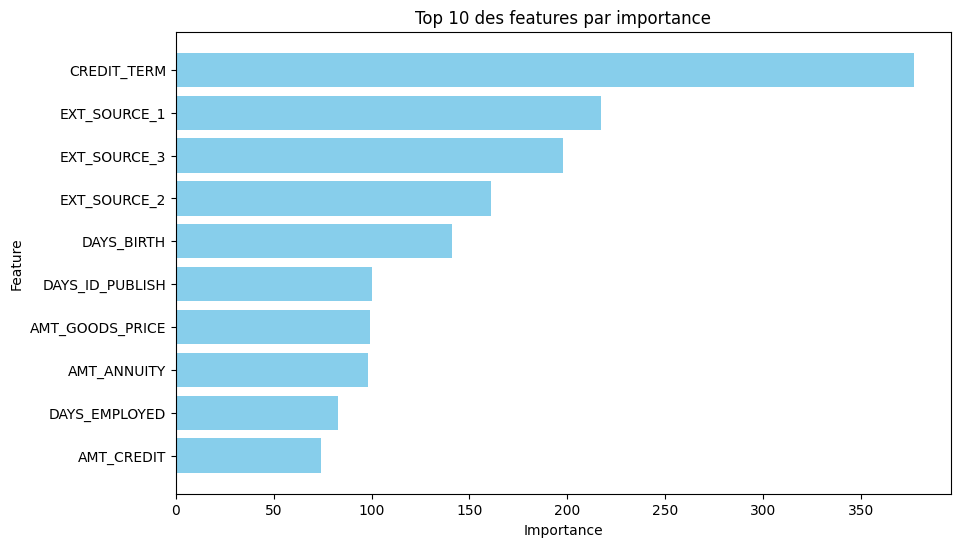

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 des features par importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

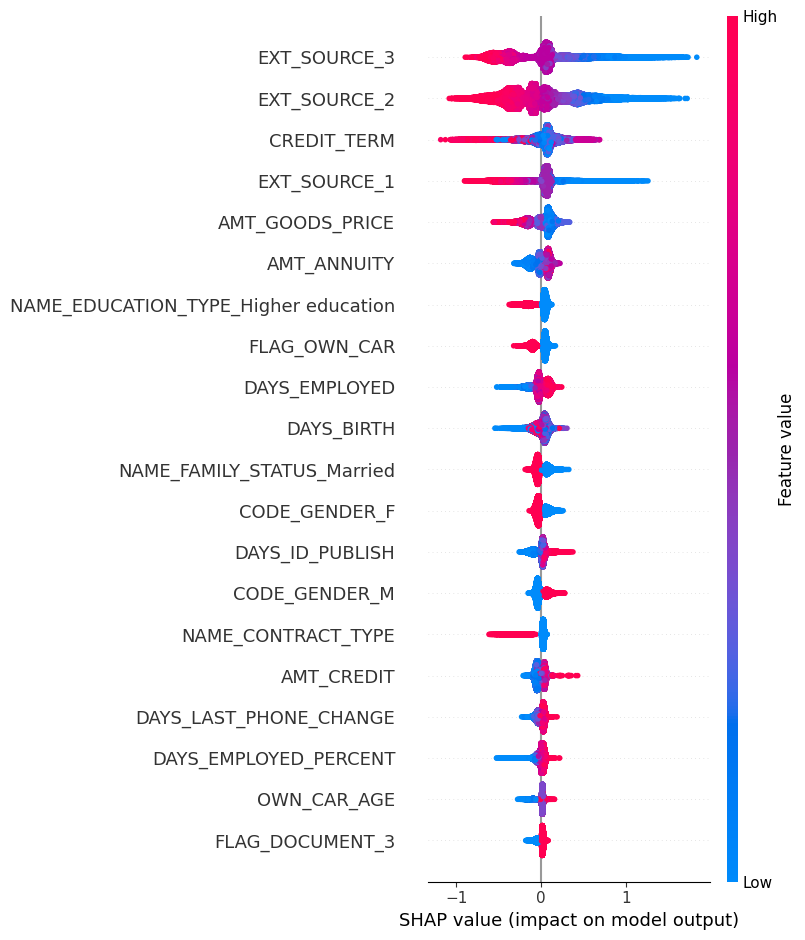

In [21]:
# Initialisation de SHAP pour LightGBM
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)  # Créer un objet Explanation

# Importance locale : force plot pour un client spécifique
client_index = 0  # Exemple : premier client dans le jeu de test

# Utilisation de shap.force_plot avec l'objet Explanation
shap.initjs()
shap.force_plot(shap_values[client_index])

# Importance globale : summary plot de SHAP
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [22]:
# 5. Sauvegarde du modèle
with open("best_lightgbm_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("Modèle sauvegardé avec succès.")


Modèle sauvegardé avec succès.


In [23]:
# 6. Entraînement du modèle avec les 5 principales features

# Sélection des 5 features les plus importantes à partir des résultats précédents
top_5_features = importance_df['Feature'].head(5).tolist()
X_train_5 = pd.DataFrame(X_train, columns=feature_names)[top_5_features]
X_test_5 = pd.DataFrame(X_test, columns=feature_names)[top_5_features]

In [24]:
# Initialisation et entraînement du modèle LightGBM avec les 5 principales features
lgbm_5_features = LGBMClassifier(class_weight='balanced', random_state=0)

[LightGBM] [Info] Number of positive: 19970, number of negative: 226038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Modèle LightGBM avec 5 features - AUC: 0.7508474161210335, Accuracy: 0.6973155781018812, Cost: 32908


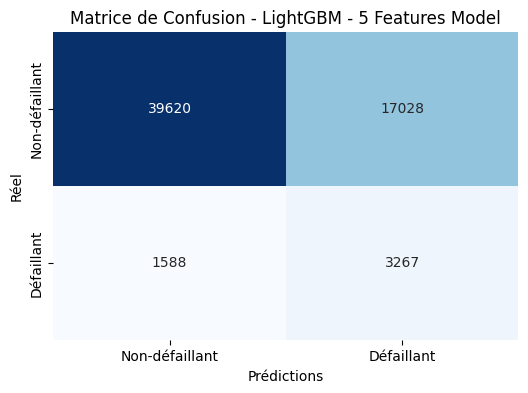

2024/11/15 10:03:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-stoat-814 at: http://127.0.0.1:5000/#/experiments/930656770713557508/runs/833bd17540b047fe819bb897119a00c9.
2024/11/15 10:03:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/930656770713557508.


Modèle avec les 5 principales features sauvegardé avec succès.


In [25]:
# Définir l'expérience par défaut au début du code
mlflow.set_experiment("OC-07 V1 (5 features)")

# Enregistrement et évaluation dans MLFlow
with mlflow.start_run():
    # Entraîner le modèle
    start_time = time.time()
    lgbm_5_features.fit(X_train_5, y_train)
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Prédiction et évaluation
    start_time = time.time()
    y_pred_5 = lgbm_5_features.predict(X_test_5)
    y_proba_5 = lgbm_5_features.predict_proba(X_test_5)[:, 1]
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calcul des métriques
    auc_5 = roc_auc_score(y_test, y_proba_5)
    accuracy_5 = accuracy_score(y_test, y_pred_5)
    conf_matrix_5 = confusion_matrix(y_test, y_pred_5)
    fp_5 = conf_matrix_5[0][1]
    fn_5 = conf_matrix_5[1][0]
    cost_5 = fp_5 + 10 * fn_5

    # Log des métriques et du modèle avec MLFlow
    mlflow.log_metric("AUC", auc_5)
    mlflow.log_metric("Accuracy", accuracy_5)
    mlflow.log_metric("Cost", cost_5)
    mlflow.log_param("model_type", "LightGBM - Top 5 Features")

    # Log du modèle et de la signature
    signature_5 = infer_signature(X_train_5, lgbm_5_features.predict(X_train_5))
    mlflow.sklearn.log_model(lgbm_5_features, "lightgbm_model_5_features", signature=signature_5)

    print(f"Modèle LightGBM avec 5 features - AUC: {auc_5}, Accuracy: {accuracy_5}, Cost: {cost_5}")
    plot_and_log_confusion_matrix("LightGBM - 5 Features Model", y_test, y_pred_5)

    # Sauvegarde du modèle localement
    with open("lightgbm_model_5_features.pkl", "wb") as model_file:
        pickle.dump(lgbm_5_features, model_file)

print("Modèle avec les 5 principales features sauvegardé avec succès.")

In [27]:
mlflow.sklearn.save_model(lgbm_5_features, "mlflow_model", signature=signature_5)

In [28]:
X_train_5

,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH
0,0.101337,0.518318,0.190893,0.817981,0.066911
1,0.159778,0.555641,0.857951,0.233510,0.343517
2,0.072286,0.518318,0.698816,0.824421,0.366629
3,0.132053,0.518318,0.904642,0.847458,0.841939
4,0.101417,0.609517,0.369325,0.826094,0.639797
...,...,...,...,...,...
246003,0.071094,0.518318,0.769364,0.820085,0.479312
246004,0.200217,0.518318,0.799617,0.426837,0.919335
246005,0.272843,0.366765,0.597163,0.334384,0.411725
246006,0.626257,0.518318,0.908326,0.456194,0.390586


In [29]:
# curl http://127.0.0.1:5002/invocations -H 'Content-Type: application/json' -d '{"data":[[0.101337,0.518318,0.190893,0.817981,0.066911]]}'